# Problem #3

## Data Ingest and Formatting

In [1]:
# Common Imports
import csv
import pathlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from prettytable import PrettyTable

import tensorflow as tf 
import numpy as np 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Activation 
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import ops
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Ensure the plot output directory exists
pathlib.Path('./out').mkdir(parents=True, exist_ok=True)

# Import the subject data as dataframes
training_data = []
for i in range(1, 9):
    training_data.append({
        "in": pd.read_csv(f'./data/sub_{i}_input.csv'),
        "out": pd.read_csv(f'./data/sub_{i}_output.csv')
    })
test_data = {
    "in": pd.read_csv('./data/sub_9_input.csv'),
    "out": pd.read_csv('./data/sub_9_output.csv')
}
exam_data = pd.read_csv('./data/sub_10_input.csv')

# Array of field names
input_fields = [
    'q_hip_right',
    'q_knee_right',
    'q_hip_left',
    'q_knee_left',
    'dq_hip_right',
    'dq_knee_right',
    'dq_hip_left',
    'dq_knee_left',
    'u_hip_right',
    'u_knee_right',
    'u_hip_left',
    'u_knee_left',
    'gyro_right_thigh_x',
    'gyro_right_thigh_y',
    'gyro_right_thigh_z',
    'gyro_left_thigh_x',
    'gyro_left_thigh_y',
    'gyro_left_thigh_z',
    'acc_right_thigh_x',
    'acc_right_thigh_y',
    'acc_right_thigh_z',
    'acc_left_thigh_x',
    'acc_left_thigh_y',
    'acc_left_thigh_z',
    'acc_gu_right_foot_x',
    'acc_gu_right_foot_y',
    'acc_gu_right_foot_z',
    'acc_gu_left_foot_x',
    'acc_gu_left_foot_y',
    'acc_gu_left_foot_z',
    'acc_gu_right_shank_x',
    'acc_gu_right_shank_y',
    'acc_gu_right_shank_z',
    'acc_gu_left_shank_x',
    'acc_gu_left_shank_y',
    'acc_gu_left_shank_z',
    'gyro_gu_right_foot_x',
    'gyro_gu_right_foot_y',
    'gyro_gu_right_foot_z',
    'gyro_gu_left_foot_x',
    'gyro_gu_left_foot_y',
    'gyro_gu_left_foot_z',
    'gyro_gu_right_shank_x',
    'gyro_gu_right_shank_y',
    'gyro_gu_right_shank_z',
    'gyro_gu_left_shank_x',
    'gyro_gu_left_shank_y',
    'gyro_gu_left_shank_z',
    'sf_right',
    'sf_left'
]
output_fields = [
    'grf_right_y',
    'grf_right_z',
    'grf_left_y',
    'grf_left_z',
]

## Machine Learning Model
### Training

In [2]:
# Create the Model
inputs = Input(shape=(len(input_fields),))
x = layers.Dense(len(input_fields)*2, activation='sigmoid')(inputs)
x = layers.Dense(len(input_fields)*2, activation='sigmoid')(x)
# x = layers.Dense(len(input_fields)*2, activation='sigmoid')(x)
outputs = layers.Dense(len(output_fields), activation='linear')(x)
model = Model(inputs=inputs, outputs=outputs, name='WalkieBoi')
model.summary()
model.build(input_shape=(None, len(input_fields)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(optimizer='rmsprop',
              loss = root_mean_squared_error,
              metrics=[RootMeanSquaredError(), R2Score()])

# Train the Model
X = np.empty((0,len(input_fields)))
Y = np.empty((0,len(output_fields)))
for i in range(1, 9):
    X = np.concatenate((X, training_data[i-1]['in'].to_numpy()), axis=0)
    Y = np.concatenate((Y, training_data[i-1]['out'].to_numpy()), axis=0)

history = model.fit(x=X, y=Y, batch_size=50, shuffle='batch', epochs=100,
                    validation_data=(test_data['in'], test_data['out']),
                    callbacks=[History(),
                               EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True)])
history = pd.DataFrame(history.history)

Model: "WalkieBoi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,604 (60.95 KB)

 Trainable params: 15,604 (60.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0987 - r2_score: -3.6498 - root_mean_squared_error: 0.1107 - val_loss: 0.0928 - val_r2_score: 0.4450 - val_root_mean_squared_error: 0.1028
Epoch 2/100
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0519 - r2_score: 0.6853 - root_mean_squared_error: 0.0593 - val_loss: 0.0881 - val_r2_score: 0.6554 - val_root_mean_squared_error: 0.0976
Epoch 3/100
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0418 - r2_score: 0.8476 - root_mean_squared_error: 0.0512 - val_loss: 0.0826 - val_r2_score: 0.6590 - val_root_mean_squared_error: 0.0950
Epoch 4/100
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0384 - r2_score: 0.8656 - root_mean_squared_error: 0.0480 - val_loss: 0.0804 - val_r2_score: 0.6985 - val_root_mean_squared_error: 0.0936
Epoch 5/100
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0366 - r2_score: 0.8835 - root_mean_squared_error: 0.0460 - val_loss: 0.0777 - val_r2_score: 0.7104 - val_root_mean_square

### Training Results

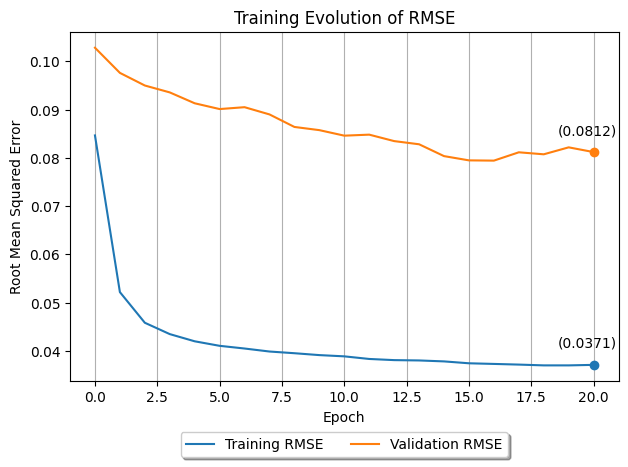

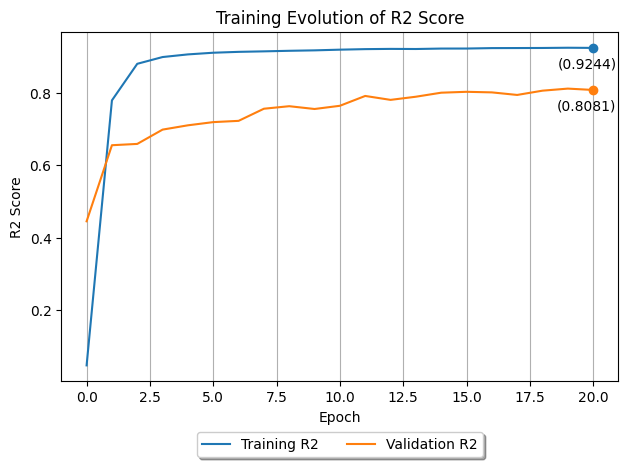

In [3]:
# Plot the RSME Training History
fig, ax = plt.subplots()
ax.plot(history['root_mean_squared_error'], label='Training RMSE')
ax.plot(history['val_root_mean_squared_error'], label='Validation RMSE')
ax.plot(len(history['root_mean_squared_error'])-1,
        history['root_mean_squared_error'].iloc[-1],
        'o', label='', color='tab:blue')
ax.text(len(history['root_mean_squared_error'])-1.25,
        history['root_mean_squared_error'].iloc[-1]+0.003,
        f'({history["root_mean_squared_error"].iloc[-1]:.4f})',
        fontsize=10, ha='center', va='bottom')
ax.plot(len(history['val_root_mean_squared_error'])-1,
        history['val_root_mean_squared_error'].iloc[-1],
        'o', label='', color='tab:orange')
ax.text(len(history['val_root_mean_squared_error'])-1.25,
        history['val_root_mean_squared_error'].iloc[-1]+0.003,
        f'({history["val_root_mean_squared_error"].iloc[-1]:.4f})',
        fontsize=10, ha='center', va='bottom')
ax.set_title('Training Evolution of RMSE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Root Mean Squared Error')
ax.xaxis.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig('./out/training_history_rmse.png')
plt.show()

# Plot the R2 Score Training History
fig, ax = plt.subplots()
ax.plot(history['r2_score'], label='Training R2')
ax.plot(history['val_r2_score'], label='Validation R2')
ax.plot(len(history['r2_score'])-1,
        history['r2_score'].iloc[-1],
        'o', label='', color='tab:blue')
ax.text(len(history['r2_score'])-1.25,
        history['r2_score'].iloc[-1]-0.065,
        f'({history["r2_score"].iloc[-1]:.4f})',
        fontsize=10, ha='center', va='bottom')
ax.plot(len(history['val_r2_score'])-1,
        history['val_r2_score'].iloc[-1],
        'o', label='', color='tab:orange')
ax.text(len(history['val_r2_score'])-1.25,
        history['val_r2_score'].iloc[-1]-0.065,
        f'({history["val_r2_score"].iloc[-1]:.4f})',
        fontsize=10, ha='center', va='bottom')
ax.set_title('Training Evolution of R2 Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('R2 Score')
ax.xaxis.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig('./out/training_history_r2.png')
plt.show()

### Prediction

In [4]:
# Predict the output for subject 10
predictions = model.predict(test_data['in'], batch_size=1)
predictions = pd.DataFrame(predictions, columns=output_fields)

# Save the predictions to a CSV file
predictions.to_csv('./out/sub_10_output.csv', index=False, float_format='%.16f')

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 16s 802us/step


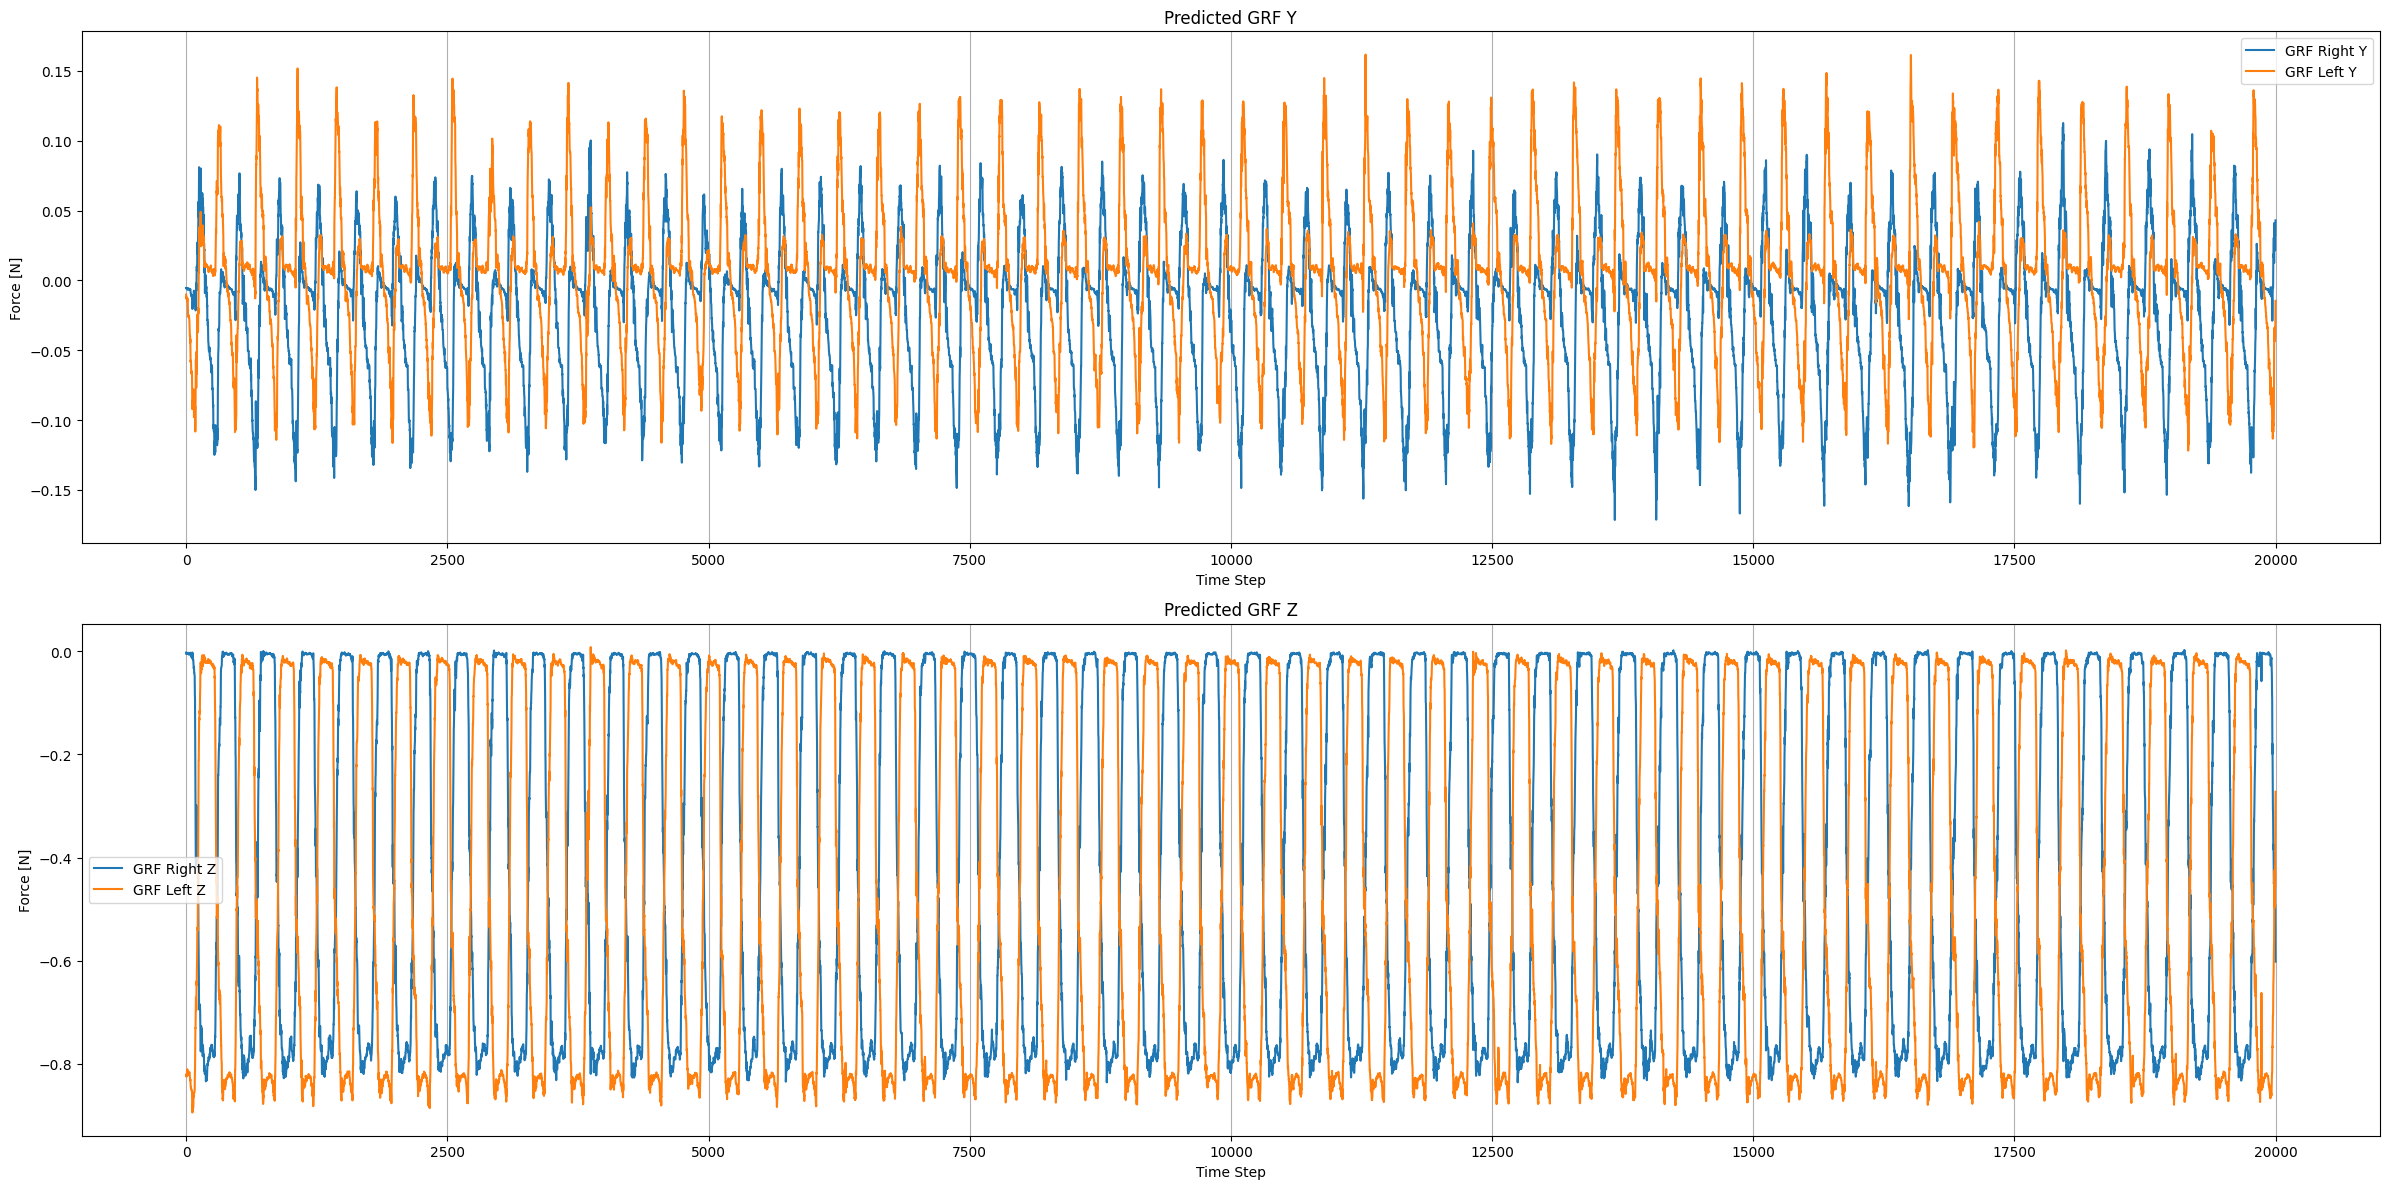

In [5]:
# Plot the Predictions
fig, axs = plt.subplots(2, 1, figsize=(24, 12))
axs[0].plot(predictions['grf_right_y'], label='GRF Right Y')
axs[0].plot(predictions['grf_left_y'], label='GRF Left Y')
axs[0].set_title('Predicted GRF Y')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Force [N]')
axs[0].legend()
axs[0].xaxis.grid()
axs[1].plot(predictions['grf_right_z'], label='GRF Right Z')
axs[1].plot(predictions['grf_left_z'], label='GRF Left Z')
axs[1].set_title('Predicted GRF Z')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Force [N]')
axs[1].legend()
axs[1].xaxis.grid()
plt.tight_layout()
plt.savefig('./out/predictions.png')
plt.show()